# Importing relevant things

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import numpy as np
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn.functional as F
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from pytorch_msssim import SSIM
from dataset import *
from device_data_loader import *
from loss import *
from model import *
from params import *
from plot import *
from rcc_trainer import *
from ucc_trainer import *


# Loading the dataset

In [2]:
splitted_dataset = np.load("../Dataset/splitted_cifar10_dataset.npz")

x_train = splitted_dataset['x_train']
print(f"x_train shape :{x_train.shape}")

y_train = splitted_dataset['y_train']
print(f"y_train shape :{y_train.shape}")

x_val = splitted_dataset['x_val']
print(f"x_val shape :{x_val.shape}")

y_val = splitted_dataset['y_val']
print(f"y_val shape :{y_val.shape}")

x_test = splitted_dataset['x_test']
print(f"x_test shape :{x_test.shape}")

y_test = splitted_dataset['y_test']
print(f"y_test shape: {y_test.shape}")


x_train shape :(40000, 32, 32, 3)
y_train shape :(40000, 1)
x_val shape :(10000, 32, 32, 3)
y_val shape :(10000, 1)
x_test shape :(10000, 32, 32, 3)
y_test shape: (10000, 1)


## Creating the dataset object

In [3]:
dataset = Dataset(x_train, y_train, x_val, y_val, x_test, y_test, debug=True, apply_augmentation=False)

Converted numpy to torch tensors


C:\Parashara\Projects\NUS projects\Sem1\Assignments\NUS-CS5242-Neural-Networks-and-Deep-Learning\Assignment 3 (CIFAR Clustering)\My test code\dataset.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_class = [torch.tensor(item).permute(2, 0, 1) for item in x[indices]]
C:\Parashara\Projects\NUS projects\Sem1\Assignments\NUS-CS5242-Neural-Networks-and-Deep-Learning\Assignment 3 (CIFAR Clustering)\My test code\dataset.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_class = [torch.tensor(item) for item in y[indices]]


Creating debug KDE dataloaders


10it [00:00, 638.50it/s]


Finished constructing the kde_datasets from the test dataset, now creating dataloaders
Created debug KDE dataloaders, now creating debug autoencoder dataloaders
Created autoencoder dataloaders, now creating ucc dataloaders


100%|██████████| 6/6 [00:00<?, ?it/s]


Created ucc dataloaders, now creating rcc dataloaders


100%|██████████| 6/6 [00:00<?, ?it/s]

Initilized all dataloaders


# Checking how one bag looks like

Checking out train


ValueError: num must be an integer with 1 <= num <= 12, not 13

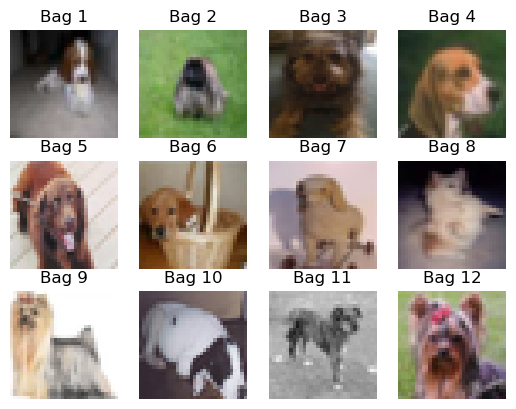

In [4]:
#printing the images in a bag 
import matplotlib.pyplot as plt

tensor_to_img_transform = transforms.ToPILImage()
dataloaders = [dataset.ucc_train_dataloader, dataset.ucc_test_dataloader, dataset.ucc_val_dataloader]
names = ["train", "test", "val"]
# params = {
#     "train":[dataset.train_mu, dataset.train_std],
#     "test": [dataset.test_mu, dataset.test_std],
#     "val": [dataset.val_mu, dataset.val_std]
# }

for ucc_dataloader, name in zip(dataloaders, names):
    print(f"Checking out {name}")
    for data in ucc_dataloader:
        batches, _ = data
        for bag in batches:
            for image_index, image in enumerate(bag):
                # image *= 255
                image = tensor_to_img_transform(image)
                plt.subplot(3, 4, image_index + 1)  # Assuming 12 images per bag
                plt.imshow(image)  # Display the image
                plt.title(f"Bag {image_index + 1}")  # Set the title
                plt.axis('off')  # Turn off axis labels
            plt.show()
            break
        break
plt.show()



## Define the class names

In [5]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# EXPERIMENT-1 : UCC Model

This model tries to replicate the paper where we have an autoencoder path and a ucc path.

Similarly experiment-2 will be the improvement model

## Creating the model instances


In [6]:
experiment1 = "ucc"
save_dir = os.path.abspath(config.weights_path)
combined_ucc_model = CombinedUCCModel().to(config.device)

#creating the trainer
ucc_trainer = UCCTrainer(experiment1, combined_ucc_model, dataset, save_dir)

Autoencoder initialized
KDE Layer initialized
UCC Predictor model initialized
Combined UCC model initialized


## Training the model

Total Epochs: 0.0% |          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/6 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


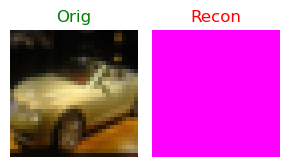

# Epoch 1
[TRAIN]: Epoch Loss: 0.8557308316230774 | AE Loss: 0.03422317902247111 | UCC Loss: 1.6772384842236836 | UCC Acc: 0.0
[VAL]: Val Loss: 1.6185803413391113 | Val AE Loss: 0.04157865047454834 | Val UCC Loss: 1.577001730600993 | Val UCC Acc: 0.16666666666666666
Going to save model ucc @ Epoch:1
Saved the model checkpoint for experiment ucc for epoch 1
------------------------------------------------------------


In [7]:
exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(1, epoch_saver_count=1)

|## Additional Training if required

In [8]:
# exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

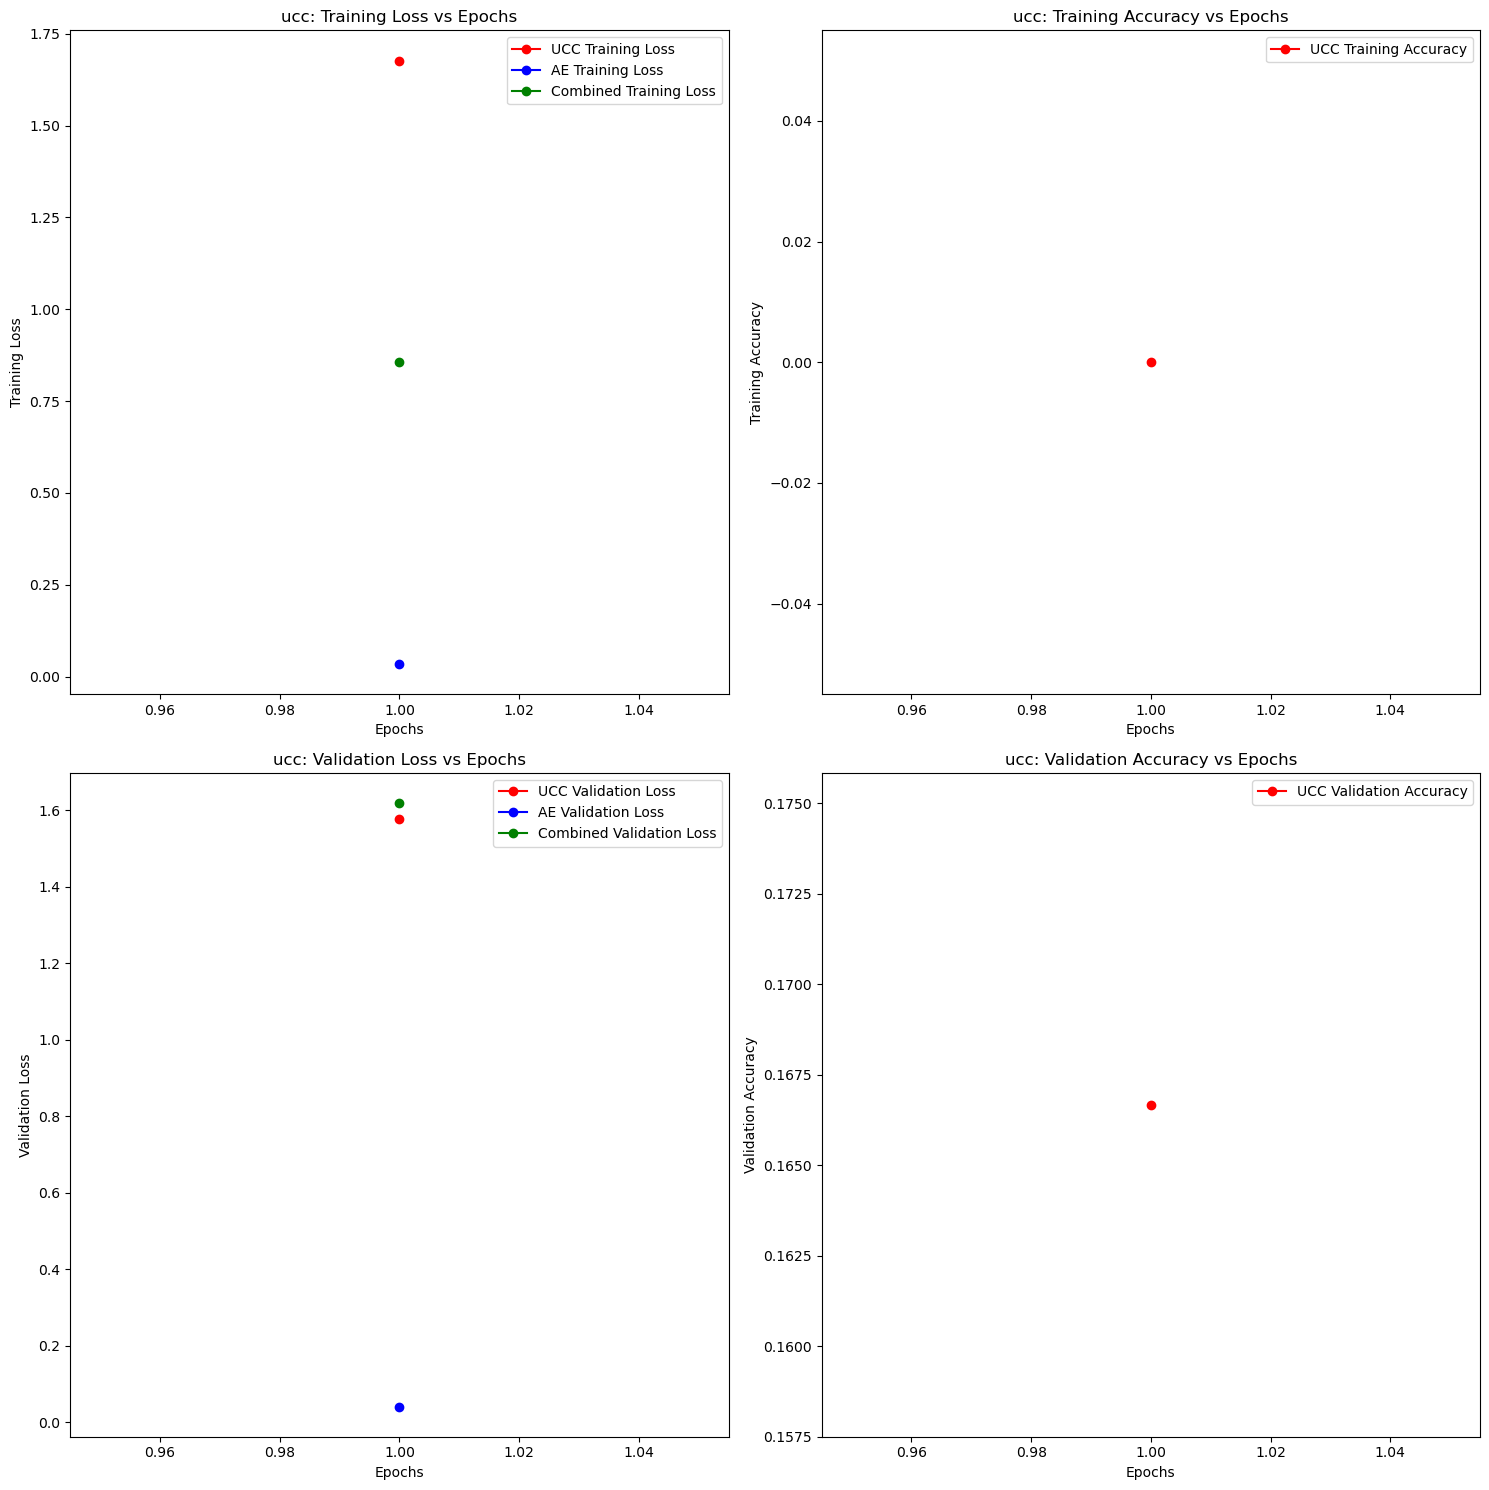

In [9]:
plot_ucc_model_stats(experiment1, exp1_epoch_numbers, exp1_training_ucc_losses, exp1_training_ae_losses, exp1_training_losses,
                     exp1_training_ucc_accuracies, exp1_val_ucc_losses, exp1_val_ae_losses, exp1_val_losses,
                     exp1_val_ucc_accuracies)

## Testing the model

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


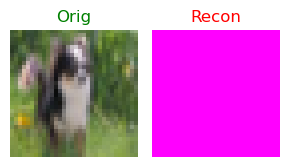

{'avg_test_loss': 1.619402954975764,
 'avg_test_ae_loss': 0.04240123430887858,
 'avg_test_ucc_loss': 1.577001730600993,
 'avg_test_ucc_training_accuracy': 0.16666666666666666}

In [10]:
ucc_trainer.test_model()

## Calculating the Min JS Divergence

In [11]:
exp1_min_js_divg = ucc_trainer.calculate_min_js_divergence()
exp1_min_js_divg

Kde Loader 0 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 0 done!
Kde Loader 1 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 1 done!
Kde Loader 2 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 2 done!
Kde Loader 3 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 3 done!
Kde Loader 4 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 4 done!
Kde Loader 5 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 5 done!
Kde Loader 6 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 6 done!
Kde Loader 7 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 7 done!
Kde Loader 8 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 8 done!
Kde Loader 9 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 9 done!
Computed all the kde's! Now finding min js divergence..
JS Divergence between 0 & 1 is 8.910386532079428e-05
JS Divergence between 0 & 2 is 8.360999345313758e-05
JS Divergence between 0 & 3 is 0.0001032637374009937
JS Divergence between 0 & 4 is 0.00018666480900719762
JS Divergence between 0 & 5 is 0.00014742441999260336
JS Divergence between 0 & 6 is 0.00012205796519992873
JS Divergence between 0 & 7 is 0.00020768900867551565
JS Divergence between 0 & 8 is 3.697495412779972e-05
JS Divergence between 0 & 9 is 0.00013702403521165252
JS Divergence between 1 & 2 is 5.709125252906233e-05
JS Divergence between 1 & 3 is 5.257379962131381e-05
JS Divergence between 1 & 4 is 7.711673970334232e-05
JS Divergence between 1 & 5 is 0.00010588661825750023
JS Divergence between 1 & 6 is 2.753965418378357e-05
JS Divergence between 1 & 7 is 3.861113509628922e-05
JS Divergence between 1 & 8 is 8.656633144710213e-05
JS Divergence between 1 & 9 is 0.000164018856594339
JS Divergence betwe

tensor(1.8331e-06, device='cuda:0', grad_fn=<MulBackward0>)

## Calculating the Clustering Accuracy

In [12]:
exp1_clustering_accuracies = ucc_trainer.calculate_clustering_accuracy()
exp1_clustering_accuracies

No of autoencoder loaders are 10
Started pure autoencoder loader 0 of length 99


  0%|          | 0/99 [00:00<?, ?it/s]

Started pure autoencoder loader 1 of length 111


  0%|          | 0/111 [00:00<?, ?it/s]

Started pure autoencoder loader 2 of length 100


  0%|          | 0/100 [00:00<?, ?it/s]

Started pure autoencoder loader 3 of length 104


  0%|          | 0/104 [00:00<?, ?it/s]

Started pure autoencoder loader 4 of length 104


  0%|          | 0/104 [00:00<?, ?it/s]

Started pure autoencoder loader 5 of length 84


  0%|          | 0/84 [00:00<?, ?it/s]

Started pure autoencoder loader 6 of length 107


  0%|          | 0/107 [00:00<?, ?it/s]

Started pure autoencoder loader 7 of length 97


  0%|          | 0/97 [00:00<?, ?it/s]

Started pure autoencoder loader 8 of length 106


  0%|          | 0/106 [00:00<?, ?it/s]

Started pure autoencoder loader 9 of length 88


  0%|          | 0/88 [00:00<?, ?it/s]

Got the latent features for all test images, now doing Kmeans


C:\Users\paras\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Got the kmeans predicted labels, now computing clustering accuracy


0.13900000000000004

In [13]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

# EXPERIMENT-2 : UCC-RCC Model

This model is an improvement to the original model as we are also trying to predict the RCC (Real Class Counts) as a separate multitask path. This approach in theory should improve the accuracy of the model.

Additionally we use the SSIM loss for the autoencoder as that is known to be a good loss function when it comes to autoencoders.



## Creating the model instances


In [14]:
experiment2 = "ucc-rcc"
save_dir = os.path.abspath(config.weights_path)
combined_rcc_model = CombinedRCCModel(config.device).to(config.device)

#creating the trainer
rcc_trainer = RCCTrainer(experiment2, combined_rcc_model, dataset, save_dir)

Autoencoder initialized
KDE Layer initialized
UCC Predictor model initialized
KDE Layer initialized
RCC Predictor module initilized
Combined RCC Predictor initialized


## Training the model

Total Epochs: 0.0% |          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/6 [00:00<?, ?it/s]

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


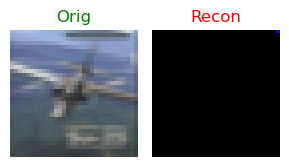

# Epoch 1
[TRAIN]: Epoch Loss: 12.85781749089559 | AE Loss: 0.03292363882064819 | UCC Loss: 1.7376670042673747 | UCC Acc: 0.3333333333333333 | RCC Loss: 36.80285962422689 | RCC Acc: 0.24305555555555555
[VAL]: Val Loss: 35.54679695765177 | Val AE Loss: 0.041732082764307656 | Val UCC Loss: 1.5053967237472534 | Val UCC Acc: 0.3333333333333333 | Val RCC Loss: 33.99966828028361 | Val RCC Acc: 0.2916666666666667
Going to save model ucc-rcc @ Epoch:1
Saved the model checkpoint for experiment ucc-rcc for epoch 1
------------------------------------------------------------


Epoch 2/2:   0%|          | 0/6 [00:00<?, ?it/s]

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


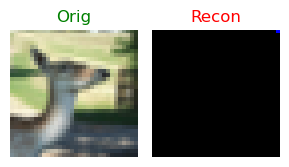

# Epoch 2
[TRAIN]: Epoch Loss: 12.028954664866129 | AE Loss: 0.03735168774922689 | UCC Loss: 1.5090843836466472 | UCC Acc: 0.16666666666666666 | RCC Loss: 34.54042641321818 | RCC Acc: 0.2986111111111111
[VAL]: Val Loss: 35.55892244974772 | Val AE Loss: 0.041732082764307656 | Val UCC Loss: 1.506408929824829 | Val UCC Acc: 0.3333333333333333 | Val RCC Loss: 34.010781606038414 | Val RCC Acc: 0.2916666666666667
Going to save model ucc-rcc @ Epoch:2
Saved the model checkpoint for experiment ucc-rcc for epoch 2
------------------------------------------------------------


In [15]:
exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(2, epoch_saver_count=1)

## Additional Training if required


In [16]:
 # exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

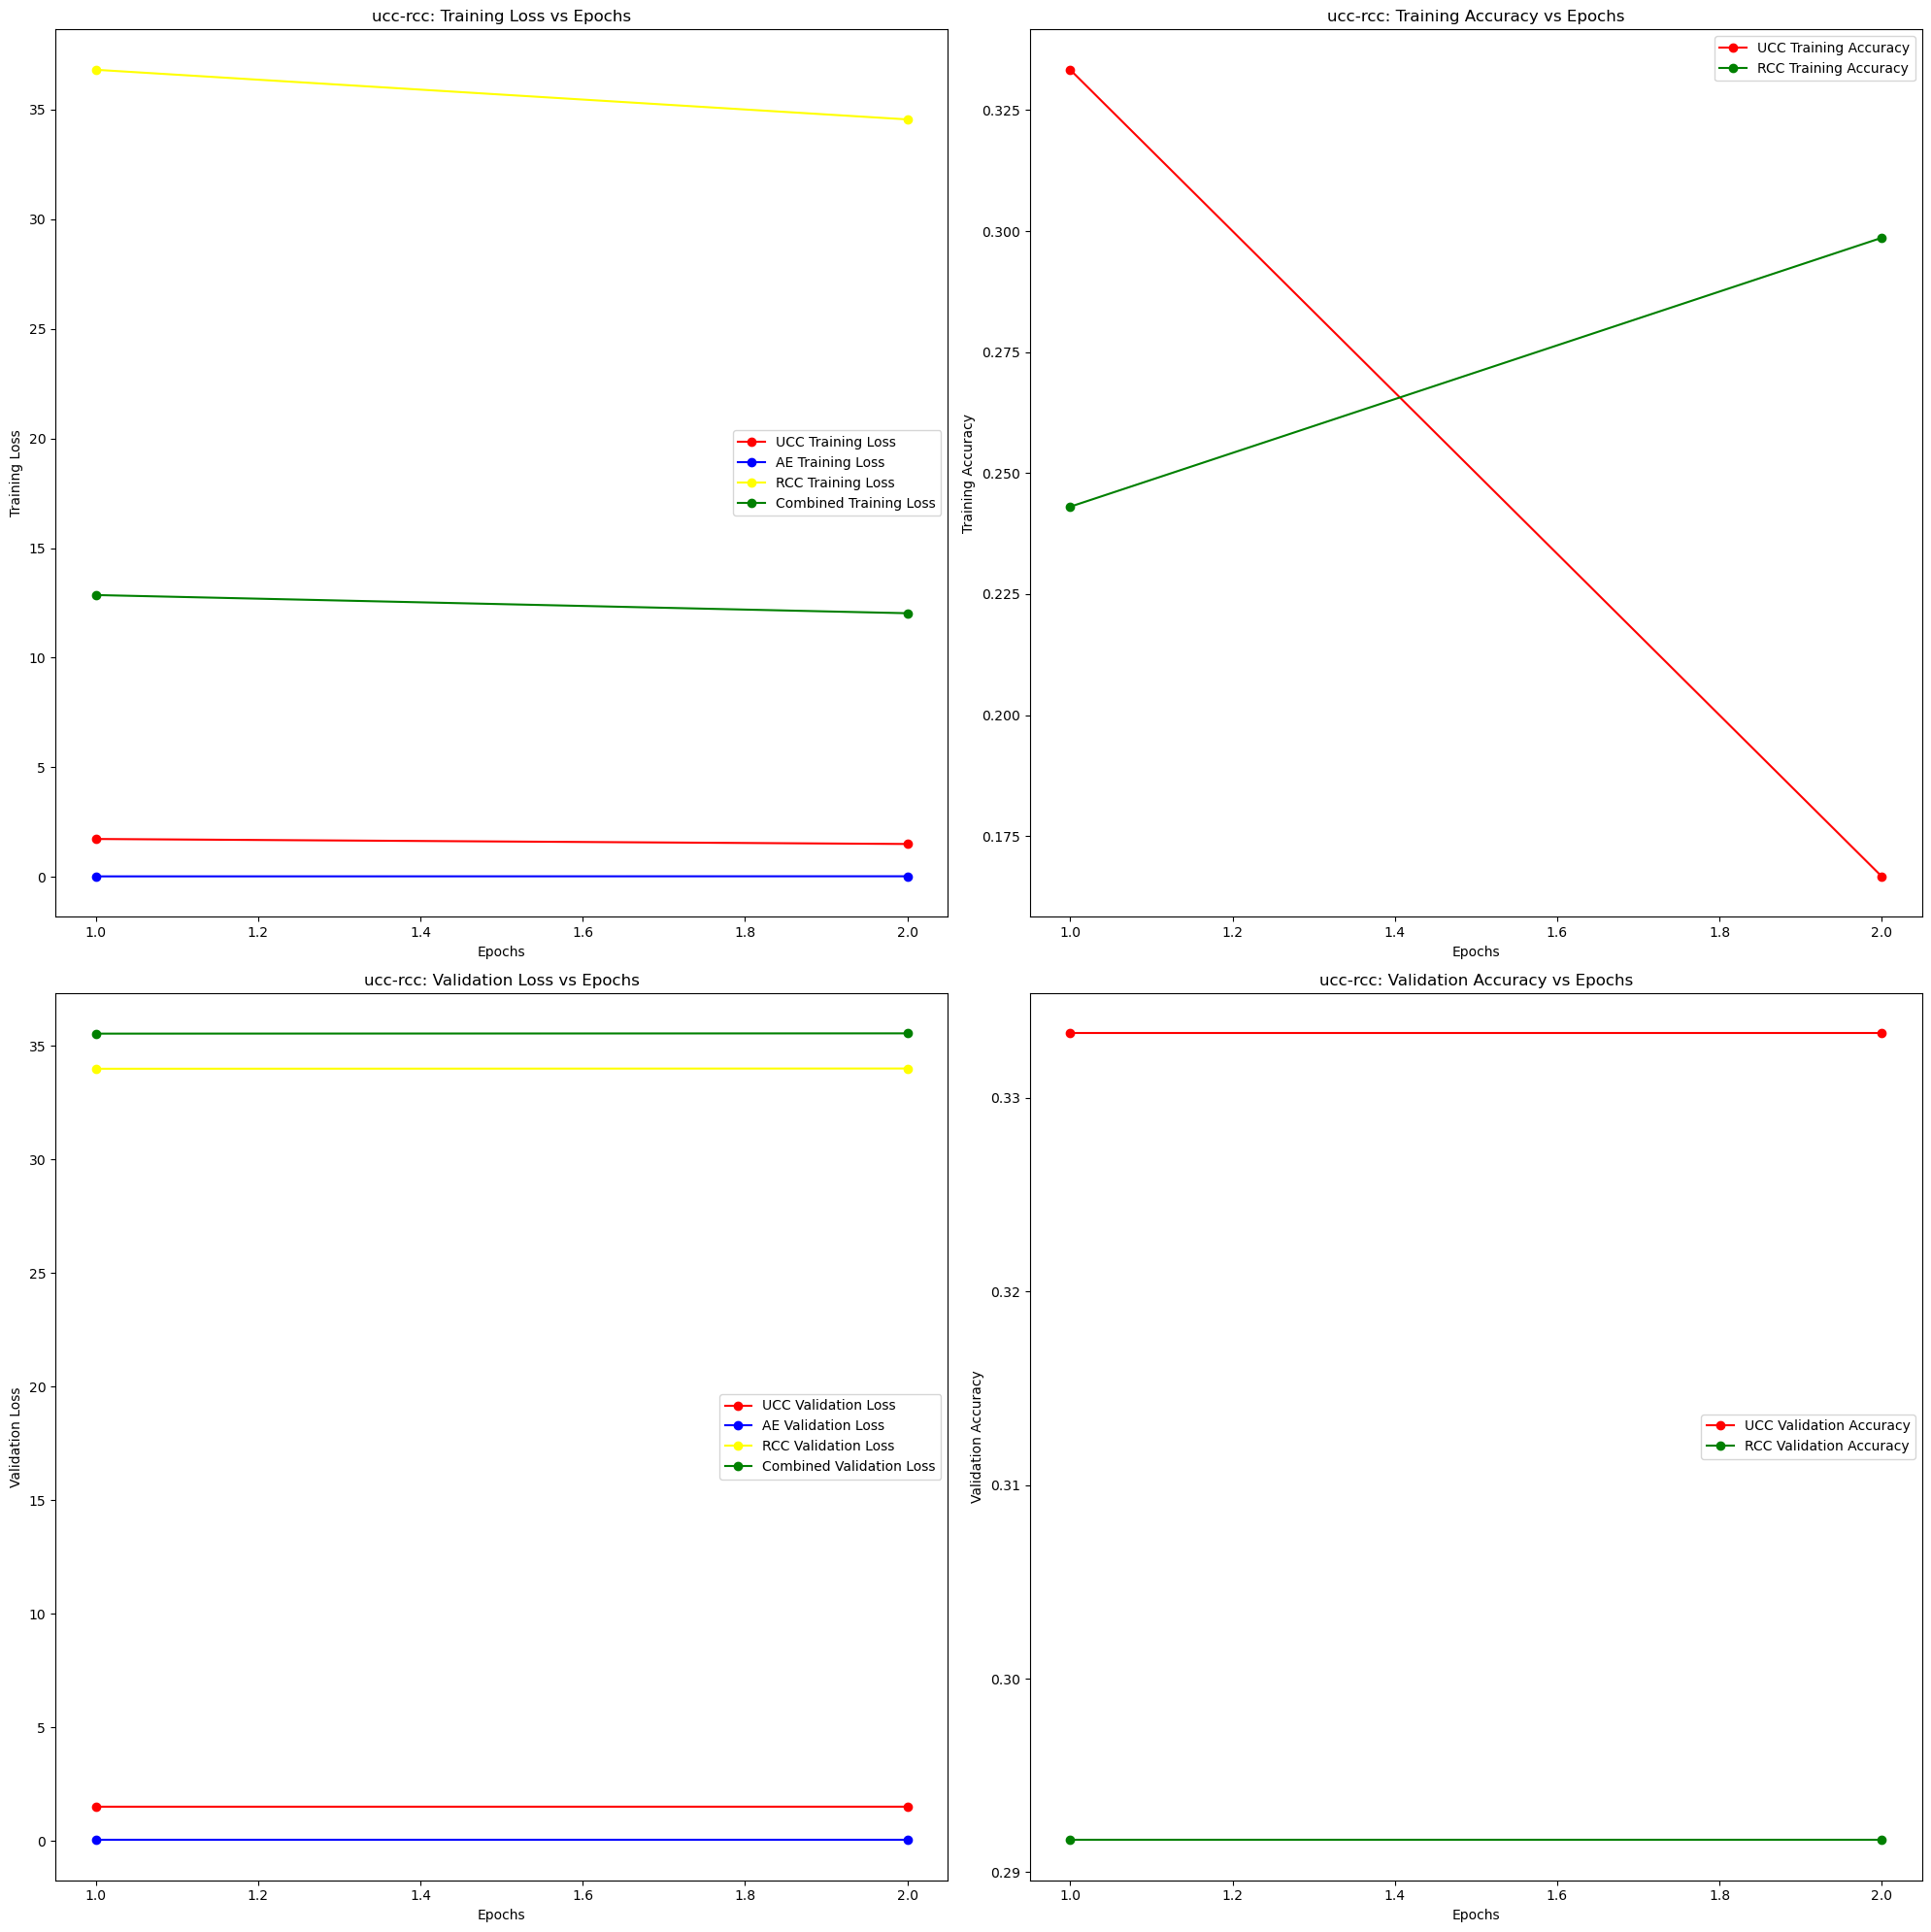

In [17]:
plot_ucc_rcc_model_stats(experiment2, exp2_epoch_numbers, exp2_training_ucc_losses, exp2_training_ae_losses,
                         exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies,
                         exp2_training_rcc_accuracies, exp2_val_ucc_losses, exp2_val_ae_losses, exp2_val_rcc_losses,
                         exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies)

## Testing the model

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


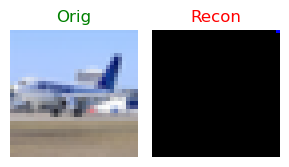

{'avg_test_loss': 35.08790810902914,
 'avg_test_ae_loss': 0.03861754139264425,
 'avg_test_ucc_loss': 1.506408929824829,
 'avg_test_rcc_loss': 33.54288180669149,
 'avg_test_ucc_training_accuracy': 0.3333333333333333,
 'avg_test_rcc_training_accuracy': 0.2986111111111111}

In [18]:
rcc_trainer.test_model()

## Calculating the Min JS Divergence

In [19]:
exp2_min_js_divg = rcc_trainer.calculate_min_js_divergence()
exp2_min_js_divg

Kde Loader 0 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 0 done!
Kde Loader 1 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 1 done!
Kde Loader 2 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 2 done!
Kde Loader 3 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 3 done!
Kde Loader 4 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 4 done!
Kde Loader 5 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 5 done!
Kde Loader 6 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 6 done!
Kde Loader 7 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 7 done!
Kde Loader 8 started!


  0%|          | 0/4 [00:00<?, ?it/s]

Kde Loader 8 done!
Kde Loader 9 started!


  0%|          | 0/3 [00:00<?, ?it/s]

Kde Loader 9 done!
Computed all the kde's! Now finding min js divergence..
JS Divergence between 0 & 1 is 3.395575186004862e-05
JS Divergence between 0 & 2 is 0.00031004188349470496
JS Divergence between 0 & 3 is 0.00026406769757159054
JS Divergence between 0 & 4 is 8.787034312263131e-05
JS Divergence between 0 & 5 is 0.00014340484631247818
JS Divergence between 0 & 6 is 0.0002697743766475469
JS Divergence between 0 & 7 is 8.935977530200034e-05
JS Divergence between 0 & 8 is 0.0003509377711452544
JS Divergence between 0 & 9 is 6.348123861243948e-05
JS Divergence between 1 & 2 is 0.00011083846038673073
JS Divergence between 1 & 3 is 0.0001206993474625051
JS Divergence between 1 & 4 is 2.964557643281296e-05
JS Divergence between 1 & 5 is 0.0001991056342376396
JS Divergence between 1 & 6 is 0.00022778061975259334
JS Divergence between 1 & 7 is 8.694443386048079e-05
JS Divergence between 1 & 8 is 0.0003378636611159891
JS Divergence between 1 & 9 is 3.153679062961601e-05
JS Divergence betwe

tensor(2.9646e-05, device='cuda:0', grad_fn=<MulBackward0>)

## Calculating the Clustering Accuracy

In [20]:
exp2_clustering_accuracies = rcc_trainer.calculate_clustering_accuracy()
exp2_clustering_accuracies

No of autoencoder loaders are 10
Started pure autoencoder loader 0 of length 99


  0%|          | 0/99 [00:00<?, ?it/s]

Started pure autoencoder loader 1 of length 111


  0%|          | 0/111 [00:00<?, ?it/s]

Started pure autoencoder loader 2 of length 100


  0%|          | 0/100 [00:00<?, ?it/s]

Started pure autoencoder loader 3 of length 104


  0%|          | 0/104 [00:00<?, ?it/s]

Started pure autoencoder loader 4 of length 104


  0%|          | 0/104 [00:00<?, ?it/s]

Started pure autoencoder loader 5 of length 84


  0%|          | 0/84 [00:00<?, ?it/s]

Started pure autoencoder loader 6 of length 107


  0%|          | 0/107 [00:00<?, ?it/s]

Started pure autoencoder loader 7 of length 97


  0%|          | 0/97 [00:00<?, ?it/s]

Started pure autoencoder loader 8 of length 106


  0%|          | 0/106 [00:00<?, ?it/s]

Started pure autoencoder loader 9 of length 88


  0%|          | 0/88 [00:00<?, ?it/s]

Got the latent features for all test images, now doing Kmeans


C:\Users\paras\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Got the kmeans predicted labels, now computing clustering accuracy


0.17799999999999996